In [1]:
import pandas as pd
import networkx as nx
import os
import re
from tqdm import tqdm

In [2]:
df = pd.read_csv('tweets_cleaned.csv')

In [3]:
df['language'].unique()

array(['en'], dtype=object)

In [4]:

# Create a directed graph
G = nx.DiGraph()

# Add nodes with attributes
for index, row in df.iterrows():
    G.add_node(row['userid'], following=row['following'], 
               followers=row['followers'], totaltweets=row['totaltweets'], user_type=row['user_type'])

# Add edges for retweets and replies
for index, row in df.iterrows():
    if pd.notna(row['original_tweet_userid']):
        G.add_edge(row['original_tweet_userid'], row['userid'])
    elif pd.notna(row['in_reply_to_user_id']):
        G.add_edge(row['in_reply_to_user_id'], row['userid'])
    elif pd.notna(row['quoted_status_userid']):
        G.add_edge(row['quoted_status_userid'], row['userid'])
    
# Your graph G is now created

In [5]:
G.number_of_nodes()

10702

In [6]:
G.number_of_edges()

90157

In [7]:
components = list(nx.strongly_connected_components(G))

# Sort components by size
components.sort(key=len, reverse=True)

# Keep the 10 largest components
largest_components = components[:10]

# Create subgraphs for each of the largest components
largest_subgraphs = [G.subgraph(c).copy() for c in largest_components]

In [8]:
for l in largest_subgraphs:
    print(l.number_of_nodes())

3834
4
3
3
2
2
2
2
2
2


In [15]:
G = largest_subgraphs[0]

In [19]:
G.number_of_edges()

35661

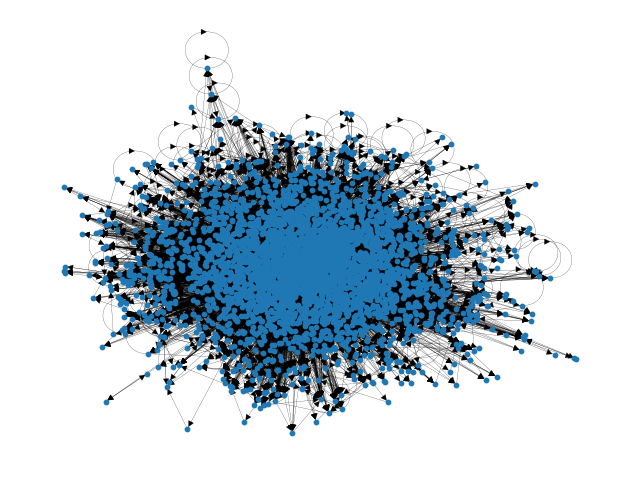

In [20]:
from matplotlib import pyplot as plt

plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}

# Layout the graph using spring layout (you can change the layout method if needed)
pos = nx.spring_layout(G, iterations=10, seed=42)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Turn off axis labels
ax.axis("off")

# Draw the network
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

# Add a title to the plot
# ax.set_title("Original Network")

# Save the plot as an image file (e.g., PNG)
plt.savefig("small_network.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot (optional, depending on your use case)
plt.show()

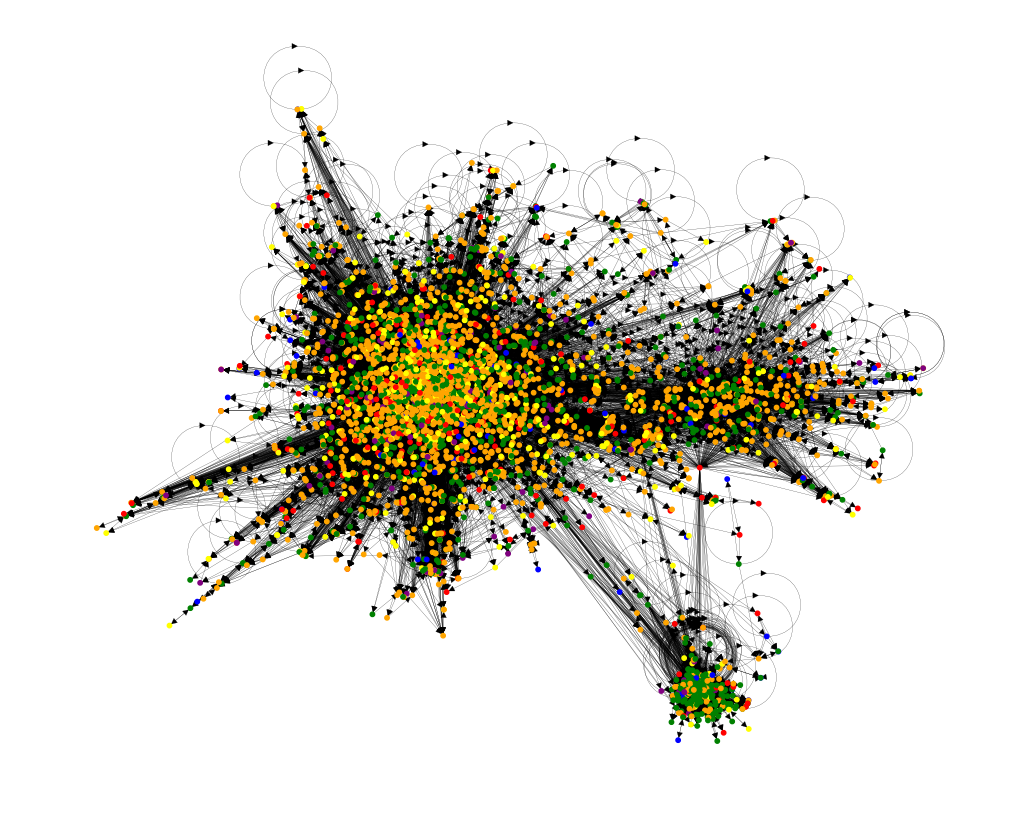

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming G is your NetworkX graph

# Step 1: Define a list of colors
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'grey', 'cyan']

# Step 2: Map user types to colors
unique_user_types = set(nx.get_node_attributes(G, 'user_type').values())
color_map = {user_type: colors[i % len(colors)] for i, user_type in enumerate(unique_user_types)}

# Step 3: Create a color map for nodes
node_colors = [color_map[G.nodes[node]['user_type']] for node in G]


# Layout the graph using spring layout (you can change the layout method if needed)
pos = nx.spring_layout(G, iterations=10, seed=42)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Turn off axis labels
ax.axis("off")

# Draw the network
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

nx.draw(G, node_color=node_colors, with_labels=False, node_size=10, width=0.15)

plt.savefig("clusters.png", format="png", dpi=300, bbox_inches="tight")

plt.show()


In [28]:
plt.savefig("clusters.png", format="png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [29]:
# Step 2: Map user types to colors
unique_user_types = set(nx.get_node_attributes(G, 'user_type').values())
user_type_to_color = {user_type: colors[i % len(colors)] for i, user_type in enumerate(unique_user_types)}
user_type_to_color

{1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'orange', 6: 'purple'}

In [30]:
import networkx as nx

# Assuming G is your NetworkX graph

# Calculating Homophily Index
same_type_edges = 0
total_edges = 0

for edge in G.edges():
    total_edges += 1
    if G.nodes[edge[0]]['user_type'] == G.nodes[edge[1]]['user_type']:
        same_type_edges += 1

homophily_index = (same_type_edges / total_edges) if total_edges > 0 else 0
print("Homophily Index:", homophily_index)

# Calculating Network Assortativity
assortativity_coefficient = nx.attribute_assortativity_coefficient(G, 'user_type')
print("Assortativity Coefficient:", assortativity_coefficient)


Homophily Index: 0.5714646252208295
Assortativity Coefficient: 0.24784504682256406


In [31]:
# Initialize counters for each user type
edge_counts = {user_type: {'intra': 0, 'inter': 0} for user_type in unique_user_types}

# Count edges
for edge in G.edges():
    user_type_start = G.nodes[edge[0]]['user_type']
    user_type_end = G.nodes[edge[1]]['user_type']

    if user_type_start == user_type_end:
        edge_counts[user_type_start]['intra'] += 1
    else:
        edge_counts[user_type_start]['inter'] += 1
        edge_counts[user_type_end]['inter'] += 1

# Calculate ratios and identify echo chamber tendencies
echo_chamber_tendency = {}
for user_type, counts in edge_counts.items():
    total = counts['intra'] + counts['inter']
    ratio = counts['intra'] / total if total > 0 else 0
    echo_chamber_tendency[user_type] = ratio

# Sorted list of user types by their tendency to form echo chambers
sorted_echo_chambers = sorted(echo_chamber_tendency.items(), key=lambda x: x[1], reverse=True)

# Print or analyze the sorted list
for user_type, ratio in sorted_echo_chambers:
    print(f"User Type: {user_type}, Echo Chamber Tendency: {ratio}")

User Type: 5, Echo Chamber Tendency: 0.49563820018365473
User Type: 3, Echo Chamber Tendency: 0.38557566506759705
User Type: 2, Echo Chamber Tendency: 0.07281553398058252
User Type: 4, Echo Chamber Tendency: 0.06395348837209303
User Type: 1, Echo Chamber Tendency: 0.044989775051124746
User Type: 6, Echo Chamber Tendency: 0.030229746070133012


In [36]:
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

In [37]:
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]


[(1216550422191587328, 0.15961586082506526),
 (1193634420000993280, 0.15961586082506526),
 (369318439, 0.07986482152028922),
 (1309939958153646081, 0.07983637816796389),
 (1402869817, 0.07983637544505741),
 (2856133189, 0.07980793619574186),
 (397430245, 0.0798079356735406),
 (20848487, 0.07980793489023874),
 (1140725219050577922, 0.07980793418153705),
 (278343846, 0.07980793410693689)]

In [38]:
data[data['userid'] == 369318439]

,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts
8074,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10149,9231,233579,2011-09-07 04:31:32,1652904969010401280,2023-05-01 05:17:08,...,34312259,holmescnn,0,0,NaN,False,0,0,NaN,2023-05-01 08:35:32.577117
13852,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10149,9232,233611,2011-09-07 04:31:32,1652992356495376386,2023-05-01 11:04:23,...,1505860122568011776,Azovsouth,0,0,NaN,False,0,0,NaN,2023-05-01 13:20:55.768788
22560,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10155,9231,233646,2011-09-07 04:31:32,1653105092126466075,2023-05-01 18:32:21,...,1216550422191587328,HerryNapit,0,0,NaN,True,1652989723307315200,0,NaN,2023-05-01 21:06:35.848373
29299,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10155,9231,233723,2011-09-07 04:31:32,1653234118077952000,2023-05-02 03:05:04,...,19536434,igorsushko,0,0,NaN,False,0,0,NaN,2023-05-02 07:07:22.616689
29318,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10155,9231,233723,2011-09-07 04:31:32,1653234633062993922,2023-05-02 03:07:06,...,71298686,TheStudyofWar,0,0,NaN,False,0,0,NaN,2023-05-02 07:07:22.482648
30261,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10155,9231,233723,2011-09-07 04:31:32,1653259276268232704,2023-05-02 04:45:02,...,383249814,gonchar4,0,0,NaN,False,0,0,NaN,2023-05-02 08:22:30.638180
39317,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10155,9231,233741,2011-09-07 04:31:32,1653397711578714115,2023-05-02 13:55:07,...,1595238230995062784,jmss77192137,0,0,NaN,False,0,0,NaN,2023-05-02 16:23:12.166074
49050,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10155,9230,233800,2011-09-07 04:31:32,1653529968876347393,2023-05-02 22:40:40,...,1519416478864400384,PStyle0ne1,0,0,NaN,False,0,0,NaN,2023-05-03 02:53:56.011521


In [39]:
nx.average_clustering(G)

0.0033647196825821644

In [40]:
colors = ["" for x in range(G.number_of_nodes())]  # initialize colors list
colors = []
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    counter += 1
    for node in list(
        com
    ):  # fill colors list with the particular color for the community nodes
        # colors[node] = color
        colors.append(color)
counter

NetworkXNotImplemented: not implemented for directed type